In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import gc

from tqdm.notebook import trange, tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K

import glob
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from keras import backend as K
from keras import backend as K
import random 

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed
     
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline

In [4]:
w, h = 304,304
border = 5   

In [5]:
train = sorted(glob.glob("Brestcancer/images/*.png"))[:64]
train_mask = sorted(glob.glob("Brestcancer/masks/*.png"))[:64]
print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')    

Total Train Images : 64
Total Mask Image : 64


In [6]:
X = np.zeros((len(train), h, w, 3), dtype=np.float32)
y = np.zeros((len(train_mask), h, w, 1), dtype=np.float32)

In [7]:
for n, (img, mimg) in tqdm(enumerate(zip(train, train_mask))):
    # print(n, img, mimg)
    # Load images
    img = load_img(img)
    x_img = img_to_array(img)
    x_img = resize(x_img, (h, w, 3), mode = 'constant', preserve_range = True)
    # # Load masks
    mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
    mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
    # # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

0it [00:00, ?it/s]

In [8]:
# Save the files in Numpy array for reusability
np.save('Brestcancer/XandY/X.npy', X)
np.save('Brestcancer/XandY/y.npy', y)
print(X.shape, y.shape)
X = np.load('Brestcancer/XandY/X.npy')
y = np.load('Brestcancer/XandY/y.npy')
print(X.shape, y.shape)

(64, 304, 304, 3) (64, 304, 304, 1)
(64, 304, 304, 3) (64, 304, 304, 1)


In [9]:
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()

(57, 304, 304, 3) (57, 304, 304, 1) (7, 304, 304, 3) (7, 304, 304, 1)


52

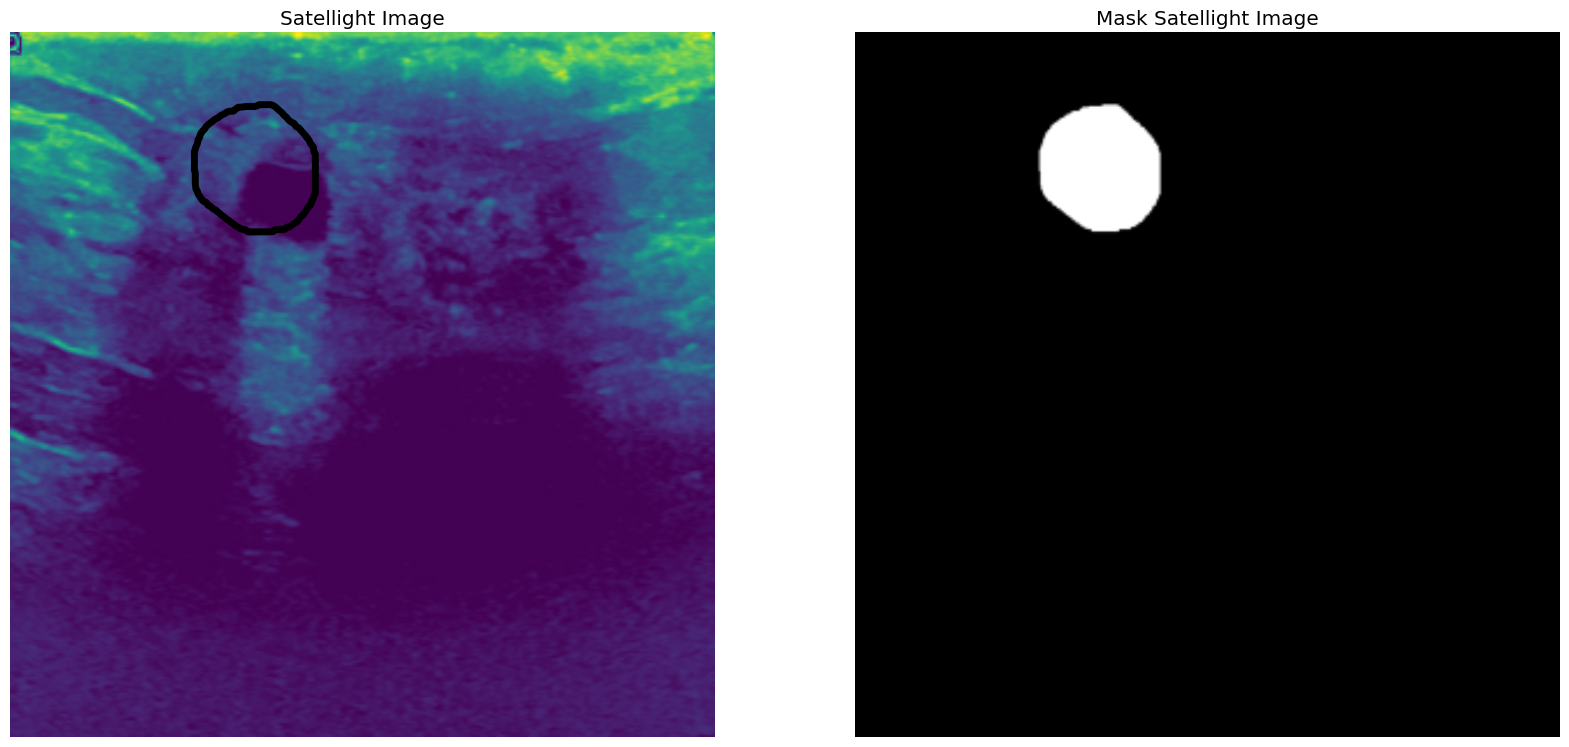

In [10]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Satellight Image')
ax1.set_axis_off()
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Satellight Image')
ax2.set_axis_off()

In [11]:


def DenseBlock(channels,inputs):

    conv1_1 = Conv2D(channels, (1, 1),activation=None, padding='same')(inputs)
    conv1_1=BatchActivate(conv1_1)
    conv1_2 = Conv2D(channels//4, (3, 3), activation=None, padding='same')(conv1_1)
    conv1_2 = BatchActivate(conv1_2)

    conv2=concatenate([inputs,conv1_2])
    conv2_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv2)
    conv2_1 = BatchActivate(conv2_1)
    conv2_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv2_1)
    conv2_2 = BatchActivate(conv2_2)

    conv3 = concatenate([inputs, conv1_2,conv2_2])
    conv3_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv3)
    conv3_1 = BatchActivate(conv3_1)
    conv3_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv3_1)
    conv3_2 = BatchActivate(conv3_2)

    conv4 = concatenate([inputs, conv1_2, conv2_2,conv3_2])
    conv4_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv4)
    conv4_1 = BatchActivate(conv4_1)
    conv4_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv4_1)
    conv4_2 = BatchActivate(conv4_2)
    result=concatenate([inputs,conv1_2, conv2_2,conv3_2,conv4_2])
    return result

def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x


def DenseUNet(image_size=304):

    filters=16
    keep_prob=0.9
    block_size=7

    inputs = Input(shape=(image_size, image_size, 3))

    conv1 = Conv2D(filters * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = BatchActivate(conv1)
    conv1 = DenseBlock(filters * 1, conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = DenseBlock(filters * 2, pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = DenseBlock(filters * 4, pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)

    convm = DenseBlock(filters * 8, pool3)

    deconv3 = Conv2DTranspose(filters * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Conv2D(filters * 4, (1, 1), activation=None, padding="same")(uconv3)
    uconv3 = BatchActivate(uconv3)
    uconv3 = DenseBlock(filters * 4, uconv3)


    deconv2 = Conv2DTranspose(filters * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Conv2D(filters * 2, (1, 1), activation=None, padding="same")(uconv2)
    uconv2 = BatchActivate(uconv2)
    uconv2 = DenseBlock(filters * 2, uconv2)

    deconv1 = Conv2DTranspose(filters * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Conv2D(filters * 1, (1, 1), activation=None, padding="same")(uconv1)
    uconv1 = BatchActivate(uconv1)
    uconv1 = DenseBlock(filters * 1, uconv1)

    outputs = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    outputs = Activation('sigmoid')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [12]:
K.clear_session()

# input_img = Input((h, w, 3), name='img')
model = DenseUNet(image_size = 304)
metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)

2023-02-22 01:18:10.311243: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-22 01:18:10.311353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (picox): /proc/driver/nvidia/version does not exist
2023-02-22 01:18:10.333059: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 304, 304, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 304, 304, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 304, 304, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 conv2d_8 (Conv2D)              (None, 304, 304, 4)  580         ['activation_7[0][0]']           
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 304, 304, 4)  16         ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 304, 304, 4)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 concatenate_3 (Concatenate)    (None, 304, 304, 32  0           ['activation[0][0]',             
                                )                                 'activation_2[0][0]',           
          

 activation_15 (Activation)     (None, 152, 152, 32  0           ['batch_normalization_15[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 152, 152, 8)  2312        ['activation_15[0][0]']          
                                                                                                  
 batch_normalization_16 (BatchN  (None, 152, 152, 8)  32         ['conv2d_16[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_16 (Activation)     (None, 152, 152, 8)  0           ['batch_normalization_16[0][0]'] 
                                                                                                  
 concatena

                                                                                                  
 activation_24 (Activation)     (None, 76, 76, 16)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 concatenate_11 (Concatenate)   (None, 76, 76, 128)  0           ['max_pooling2d_1[0][0]',        
                                                                  'activation_18[0][0]',          
                                                                  'activation_20[0][0]',          
                                                                  'activation_22[0][0]',          
                                                                  'activation_24[0][0]']          
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 38, 38, 128)  0          ['concatenate_11[0][0]']         
          

                                                                  'activation_32[0][0]']          
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 76, 76, 64)  147520      ['concatenate_15[0][0]']         
 ose)                                                                                             
                                                                                                  
 concatenate_16 (Concatenate)   (None, 76, 76, 192)  0           ['conv2d_transpose[0][0]',       
                                                                  'concatenate_11[0][0]']         
                                                                                                  
 conv2d_33 (Conv2D)             (None, 76, 76, 64)   12352       ['concatenate_16[0][0]']         
                                                                                                  
 batch_nor

 concatenate_20 (Concatenate)   (None, 76, 76, 128)  0           ['activation_33[0][0]',          
                                                                  'activation_35[0][0]',          
                                                                  'activation_37[0][0]',          
                                                                  'activation_39[0][0]',          
                                                                  'activation_41[0][0]']          
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 152, 152, 32  36896      ['concatenate_20[0][0]']         
 spose)                         )                                                                 
                                                                                                  
 concatenate_21 (Concatenate)   (None, 152, 152, 96  0           ['conv2d_transpose_1[0][0]',     
          

                                                                                                  
 batch_normalization_49 (BatchN  (None, 152, 152, 32  128        ['conv2d_49[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_49 (Activation)     (None, 152, 152, 32  0           ['batch_normalization_49[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_50 (Conv2D)             (None, 152, 152, 8)  2312        ['activation_49[0][0]']          
                                                                                                  
 batch_normalization_50 (BatchN  (None, 152, 152, 8)  32         ['conv2d_50[0][0]']              
 ormalizat

 conv2d_57 (Conv2D)             (None, 304, 304, 4)  580         ['activation_56[0][0]']          
                                                                                                  
 batch_normalization_57 (BatchN  (None, 304, 304, 4)  16         ['conv2d_57[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_57 (Activation)     (None, 304, 304, 4)  0           ['batch_normalization_57[0][0]'] 
                                                                                                  
 concatenate_29 (Concatenate)   (None, 304, 304, 28  0           ['activation_51[0][0]',          
                                )                                 'activation_53[0][0]',          
                                                                  'activation_55[0][0]',          
          

In [14]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-DenseUnet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataDenseUnet.csv"),
    TensorBoard(log_dir='./logs')
]

In [15]:
results = model.fit(X_train, y_train, batch_size=6, epochs=5, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True, workers=31)

Epoch 1/5
10/10 [==============================] - ETA: 0s - loss: 0.5273 - accuracy: 0.8362 - auc: 0.5514 - sensitivity_at_specificity: 0.5681 - specificity_at_sensitivity: 0.5739
Epoch 1: val_loss improved from inf to 0.61940, saving model to model-DenseUnet.h5
10/10 [==============================] - 114s 10s/step - loss: 0.5273 - accuracy: 0.8362 - auc: 0.5514 - sensitivity_at_specificity: 0.5681 - specificity_at_sensitivity: 0.5739 - val_loss: 0.6194 - val_accuracy: 0.9593 - val_auc: 0.4720 - val_sensitivity_at_specificity: 0.3450 - val_specificity_at_sensitivity: 0.4536 - lr: 0.0010
Epoch 2/5
10/10 [==============================] - ETA: 0s - loss: 0.3862 - accuracy: 0.9335 - auc: 0.5176 - sensitivity_at_specificity: 0.5297 - specificity_at_sensitivity: 0.5023 
Epoch 2: val_loss improved from 0.61940 to 0.57680, saving model to model-DenseUnet.h5
10/10 [==============================] - 102s 10s/step - loss: 0.3862 - accuracy: 0.9335 - auc: 0.5176 - sensitivity_at_specificity: 0.

In [16]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,auc,sensitivity_at_specificity,specificity_at_sensitivity,val_loss,val_accuracy,val_auc,val_sensitivity_at_specificity,val_specificity_at_sensitivity,lr
4,0.249989,0.942321,0.610542,0.628822,0.646070,0.394239,0.959420,0.482974,0.375057,0.468426,0.001
3,0.274118,0.941752,0.551790,0.531549,0.550221,0.449084,0.959420,0.485861,0.422634,0.458750,0.001
2,0.313177,0.940449,0.549839,0.566817,0.550349,0.514103,0.959420,0.487817,0.480230,0.396979,0.001
1,0.386229,0.933541,0.517559,0.529706,0.502264,0.576801,0.959420,0.500186,0.502514,0.507705,0.001
0,0.527311,0.836234,0.551361,0.568053,0.573931,0.619401,0.959311,0.472012,0.345040,0.453624,0.001


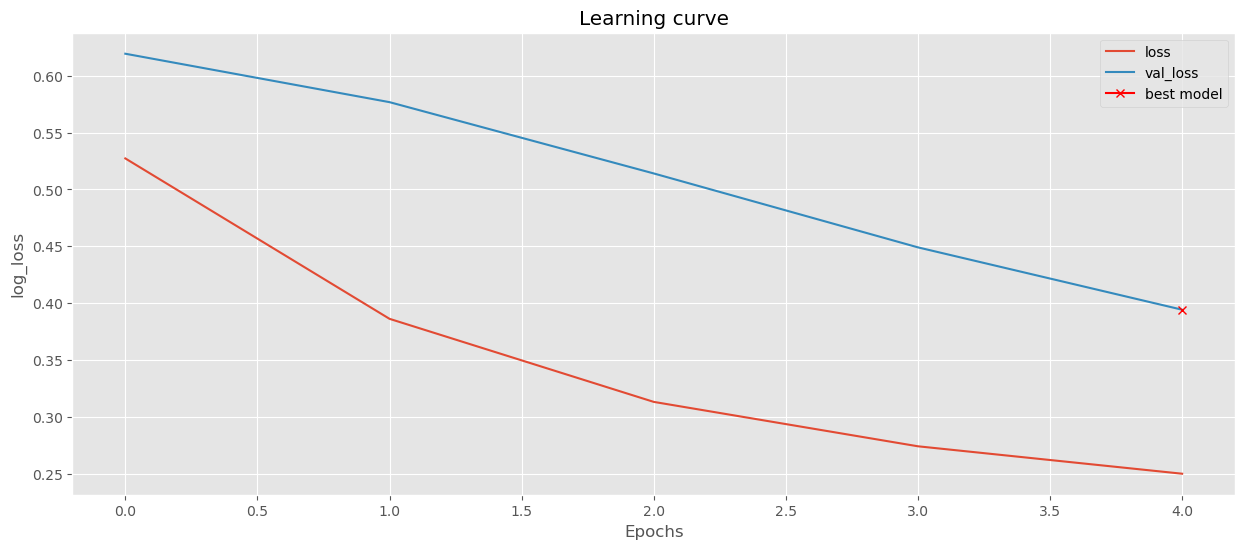

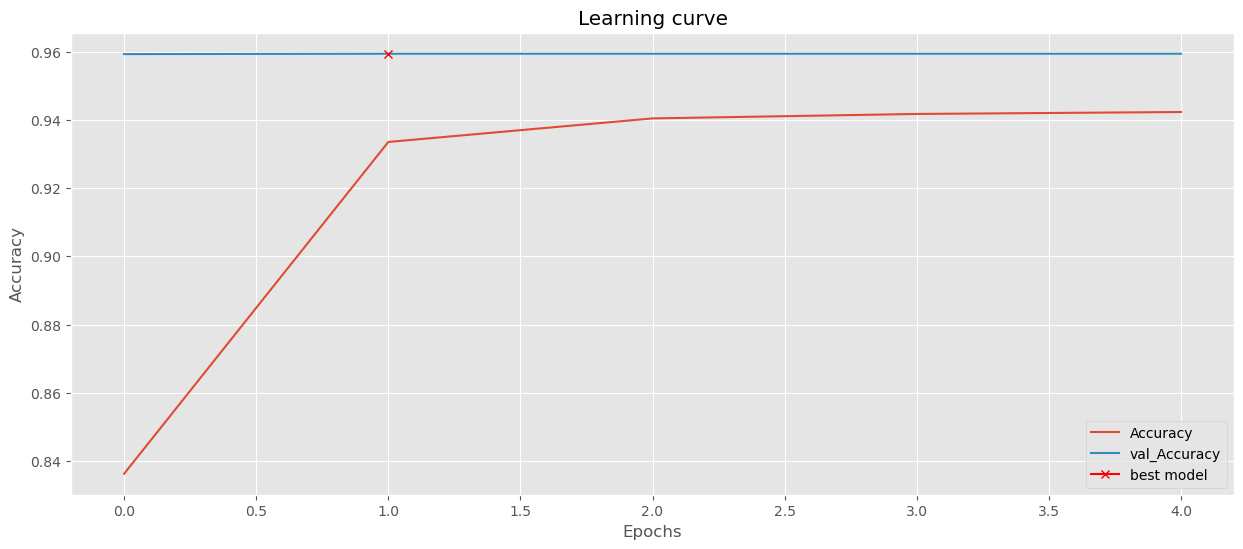

In [17]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [18]:
model.load_weights('model-DenseUnet.h5')
model.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 2s 2s/step - loss: 0.3942 - accuracy: 0.9594 - auc: 0.4830 - sensitivity_at_specificity: 0.3751 - specificity_at_sensitivity: 0.4684


[0.39423879981040955,
 0.9594195485115051,
 0.48297369480133057,
 0.3750571310520172,
 0.46842554211616516]

In [28]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

2023-02-22 01:28:47.138295: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 567803904 exceeds 10% of free system memory.


1/1 [==============================] - 2s 2s/step


In [29]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [30]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Brest cancer Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Brest cancer Mask Image')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Brest cancer Image Predicted')
    ax[2].set_axis_off()
    
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Brest cancer Mask Image Predicted binary');
    ax[3].set_axis_off()

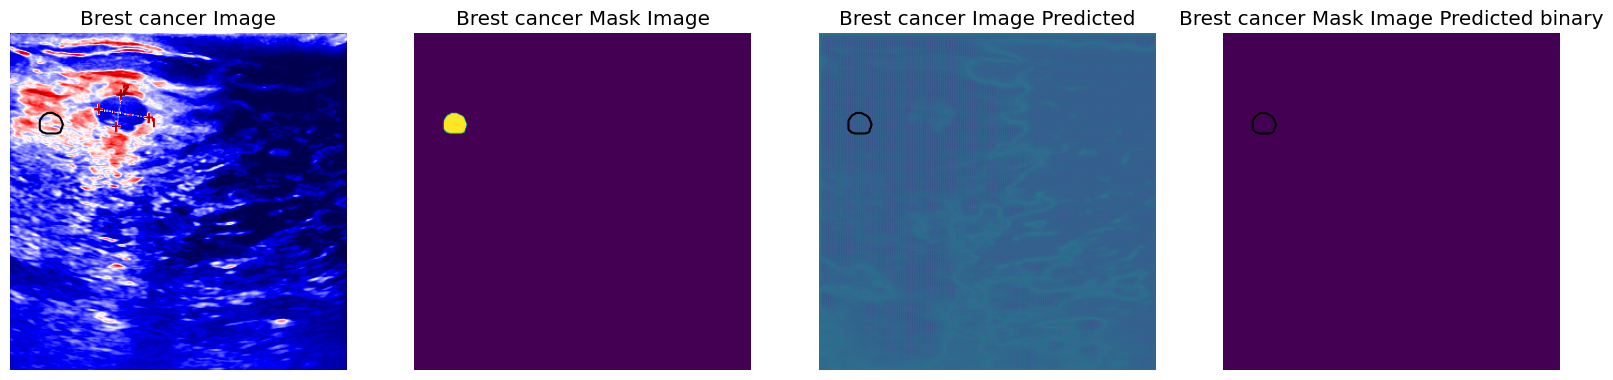

In [31]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

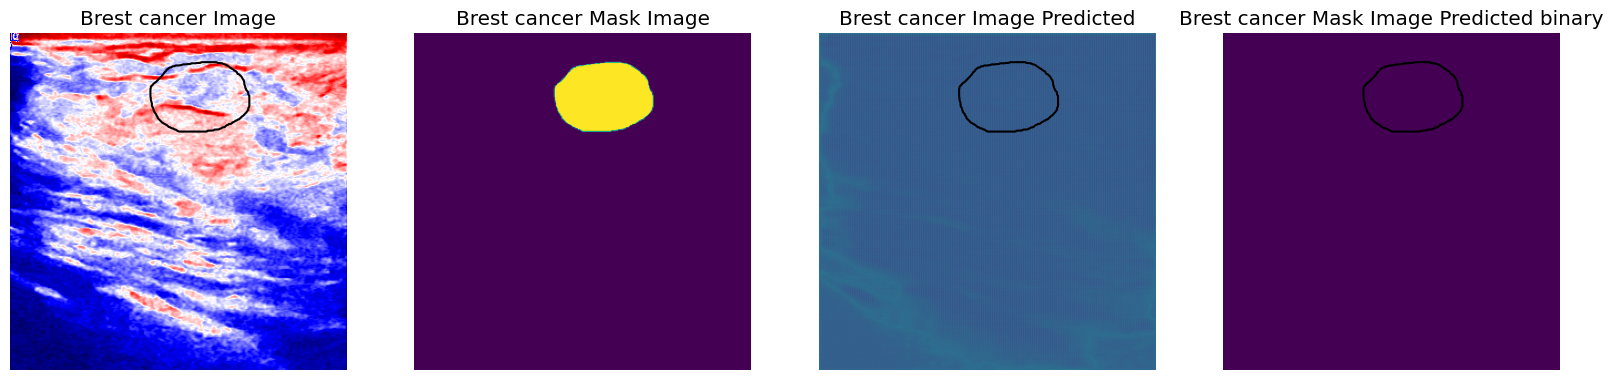

In [32]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

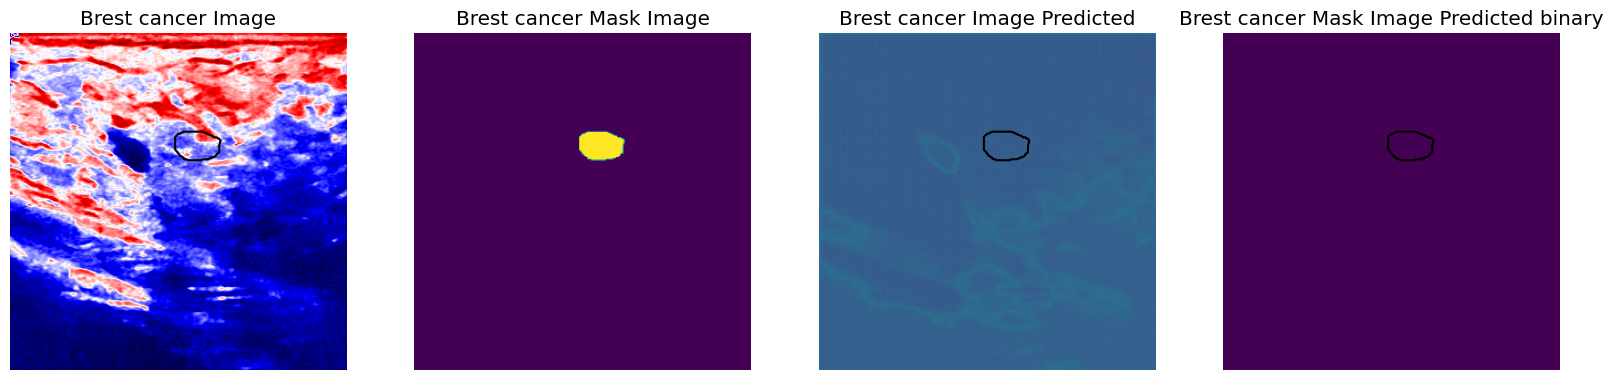

In [33]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

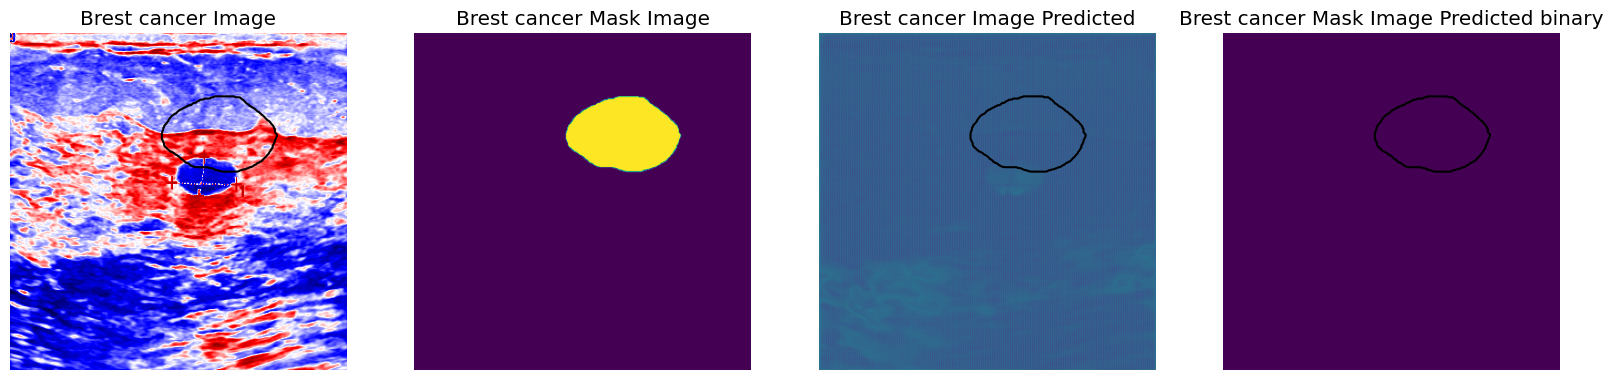

In [34]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

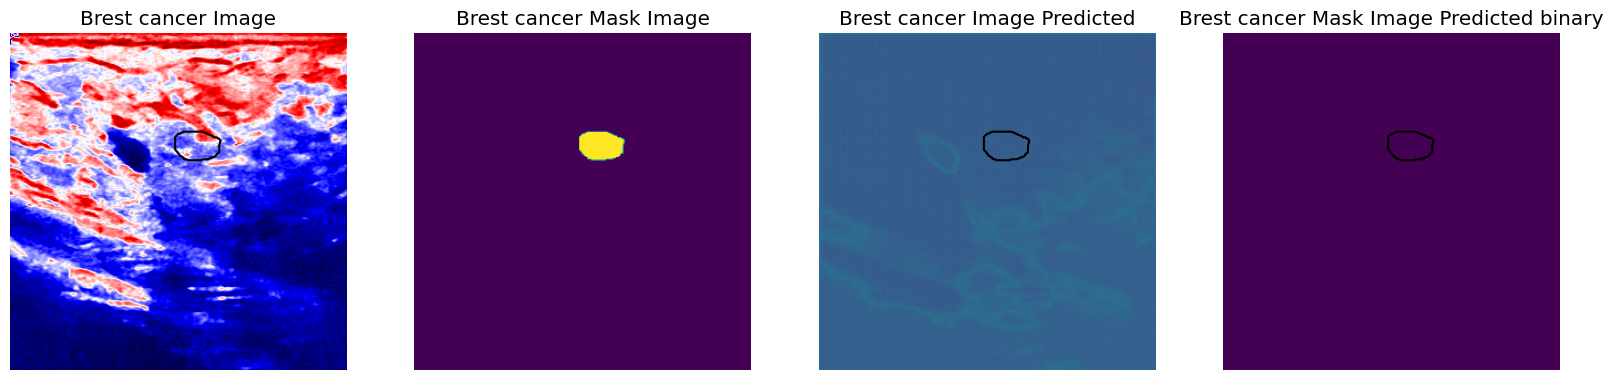

In [35]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

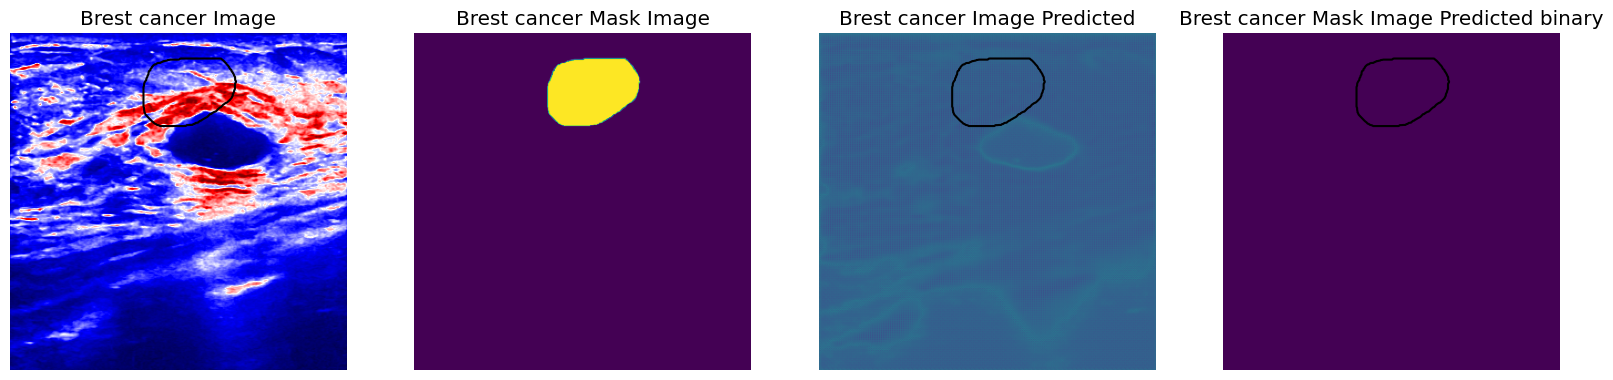

In [36]:
plot_sample(X_train, y_train, preds_train, preds_train_t)